In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

# -----------------------------
# 1. Data Preprocessing
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

classes = train_ds.classes
print("Classes:", classes)

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']


In [2]:
print("Total training images:", len(train_ds))
print("Total validation images:", len(val_ds))
print("Total test images:", len(test_ds))

total_images = len(train_ds) + len(val_ds) + len(test_ds)
print("Total images in dataset:", total_images)

Total training images: 1917
Total validation images: 504
Total test images: 630
Total images in dataset: 3051


In [3]:
ignore_folder = "random_occlusion"

def count_images_ignore_folder(dataset, ignore_folder):
    count = 0
    for img_path, label in dataset.samples:
        # Skip if the image path contains the ignore_folder
        if ignore_folder not in img_path.split("/"):
            count += 1
    return count

train_count = count_images_ignore_folder(train_ds, ignore_folder)
val_count   = count_images_ignore_folder(val_ds, ignore_folder)
test_count  = count_images_ignore_folder(test_ds, ignore_folder)

total_count = train_count + val_count + test_count

print("Training images (excluding '{}'): {}".format(ignore_folder, train_count))
print("Validation images (excluding '{}'): {}".format(ignore_folder, val_count))
print("Test images (excluding '{}'): {}".format(ignore_folder, test_count))
print("Total images (excluding '{}'): {}".format(ignore_folder, total_count))

Training images (excluding 'random_occlusion'): 1704
Validation images (excluding 'random_occlusion'): 448
Test images (excluding 'random_occlusion'): 560
Total images (excluding 'random_occlusion'): 2712


In [4]:
ignore_folder = "random_occlusionw"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution', 'dirty_lens'}
Validation folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution', 'dirty_lens'}
Test folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'random_occlusion', 'motion_blur', 'low_resolution', 'dirty_lens'}


In [5]:
ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    # Keep only samples where ignore_folder is NOT in the path
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]  # Update targets accordingly
    return dataset

# Create original datasets
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Filter out 'random_occlusion' folder
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Classes (will remain the same)
classes = train_ds.classes
print("Classes:", classes)

# Show counts
print("Final Training images:", len(train_ds))
print("Final Validation images:", len(val_ds))
print("Final Test images:", len(test_ds))
print("Total images after filtering:", len(train_ds) + len(val_ds) + len(test_ds))

Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
Final Training images: 1704
Final Validation images: 448
Final Test images: 560
Total images after filtering: 2712


In [6]:
ignore_folder = "random_occlusion"

def get_included_folders(dataset, ignore_folder):
    included = set()
    for img_path, label in dataset.samples:
        # Split the path into parts and ignore if ignore_folder is in the path
        if ignore_folder not in img_path.split("/"):
            # The folder name just above the image (or the class folder)
            folder_name = img_path.split("/")[-2]
            included.add(folder_name)
    return included

train_folders = get_included_folders(train_ds, ignore_folder)
val_folders   = get_included_folders(val_ds, ignore_folder)
test_folders  = get_included_folders(test_ds, ignore_folder)

print("Training folders considered:", train_folders)
print("Validation folders considered:", val_folders)
print("Test folders considered:", test_folders)

Training folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens'}
Validation folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens'}
Test folders considered: {'original', 'blur', 'gaussian_noise', 'lens_flare', 'chromatic_aberration', 'motion_blur', 'low_resolution', 'dirty_lens'}


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import os
import tempfile

# -----------------------------
# 1. Data Preprocessing with Filtering (Swin Transformer - 224x224)
# -----------------------------
data_dir = "/kaggle/input/ju-cricket/Cricket_Dataset_final/Task_B"

# Swin Transformer uses 224x224 input size
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Swin Transformer input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

ignore_folder = "random_occlusion"

def filter_samples(dataset, ignore_folder):
    """Filter out samples containing the ignore_folder in their path"""
    filtered_samples = [s for s in dataset.samples if ignore_folder not in s[0].split("/")]
    dataset.samples = filtered_samples
    dataset.targets = [s[1] for s in filtered_samples]
    return dataset

# Create and filter datasets
print("🔄 Loading and filtering datasets for Swin Transformer...")
train_ds = datasets.ImageFolder(f"{data_dir}/train/Fielding", transform=transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val/Fielding", transform=transform)
test_ds  = datasets.ImageFolder(f"{data_dir}/test/Fielding", transform=transform)

# Apply filtering
train_ds = filter_samples(train_ds, ignore_folder)
val_ds   = filter_samples(val_ds, ignore_folder)
test_ds  = filter_samples(test_ds, ignore_folder)

# Create DataLoaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# Display information
classes = train_ds.classes
print(f"✅ Classes: {classes}")
print(f"📊 Dataset Statistics:")
print(f"│ Training images: {len(train_ds)}")
print(f"│ Validation images: {len(val_ds)}")
print(f"│ Test images: {len(test_ds)}")
print(f"│ Total images (after filtering): {len(train_ds) + len(val_ds) + len(test_ds)}")
print(f"│ Excluded folder: '{ignore_folder}'")
print(f"│ Number of classes: {len(classes)}")

# -----------------------------
# 2. Pretrained Swin Transformer Model
# -----------------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pretrained Swin Transformer (Swin-T)
print("🔄 Loading pretrained Swin Transformer (Swin-T) from ImageNet...")
model = models.swin_t(pretrained=True)

# Replace final classification layer
# Swin Transformer uses model.head (similar to ViT)
num_features = model.head.in_features  # Get input features (768 for Swin-T)
model.head = nn.Linear(num_features, len(classes))  # Replace final layer
model = model.to(device)

print(f"✅ Model loaded with {len(classes)} output classes")

# Calculate model parameters and size
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Calculate model file size
with tempfile.NamedTemporaryFile(delete=False, suffix='.pth') as tmp_file:
    torch.save(model.state_dict(), tmp_file.name)
    model_size_mb = os.path.getsize(tmp_file.name) / (1024 * 1024)
    os.unlink(tmp_file.name)

print(f"📊 Total parameters: {total_params:,}")
print(f"📊 Trainable parameters: {trainable_params:,}")
print(f"📊 Model file size: {model_size_mb:.2f} MB")
print(f"📋 Model Architecture:")
print(f"│ Input size: (3, 224, 224)")
print(f"│ Swin-T features: 768")
print(f"│ Output classes: {len(classes)}")
print(f"│ Patch size: 4x4")
print(f"│ Window size: 7x7")
print(f"│ Layers: [2, 2, 6, 2] per stage")
print(f"│ Hierarchical: Multi-scale feature maps")


🔄 Loading and filtering datasets for Swin Transformer...
✅ Classes: ['boundary_save', 'catching_a_ball', 'diving_stop', 'run_out', 'stumping']
📊 Dataset Statistics:
│ Training images: 1704
│ Validation images: 448
│ Test images: 560
│ Total images (after filtering): 2712
│ Excluded folder: 'random_occlusion'
│ Number of classes: 5
Using device: cuda
🔄 Loading pretrained Swin Transformer (Swin-T) from ImageNet...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Swin_T_Weights.IMAGENET1K_V1`. You can also use `weights=Swin_T_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:00<00:00, 176MB/s]


✅ Model loaded with 5 output classes
📊 Total parameters: 27,523,199
📊 Trainable parameters: 27,523,199
📊 Model file size: 105.28 MB
📋 Model Architecture:
│ Input size: (3, 224, 224)
│ Swin-T features: 768
│ Output classes: 5
│ Patch size: 4x4
│ Window size: 7x7
│ Layers: [2, 2, 6, 2] per stage
│ Hierarchical: Multi-scale feature maps



📋 Training Configuration:
│ Model: Swin Transformer Tiny (pretrained)
│ Optimizer: Adam (lr=0.0001)
│ Loss Function: CrossEntropyLoss
│ Batch Size: 32
│ Device: cuda
│ Data: Filtered (excluding 'random_occlusion')

🚀 Starting Swin Transformer Fine-tuning for 50 epochs...

📈 Epoch 1/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:45<00:00,  1.19it/s, Loss=0.7588, Acc=0.7177]


✅ Training completed in 45.48s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:07<00:00,  1.96it/s, Loss=0.8217, Acc=0.6629]


✅ Validation completed in 7.15s
🌟 New best model found! Validation Loss: 0.8217

📊 Epoch 1 Summary:
│ Train Loss: 0.7588 | Train Acc: 0.7177
│ Val Loss:   0.8217 | Val Acc:   0.6629
│ Train Time: 45.48s | Val Time: 7.15s
│ Total Epoch Time: 52.63s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 2/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:34<00:00,  1.55it/s, Loss=0.1190, Acc=0.9601]


✅ Training completed in 34.92s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.92it/s, Loss=1.2158, Acc=0.6496]


✅ Validation completed in 4.80s

📊 Epoch 2 Summary:
│ Train Loss: 0.1190 | Train Acc: 0.9601
│ Val Loss:   1.2158 | Val Acc:   0.6496
│ Train Time: 34.92s | Val Time: 4.80s
│ Total Epoch Time: 39.73s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 3/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:36<00:00,  1.47it/s, Loss=0.0468, Acc=0.9894]


✅ Training completed in 36.78s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.85it/s, Loss=0.9472, Acc=0.7411]


✅ Validation completed in 4.91s

📊 Epoch 3 Summary:
│ Train Loss: 0.0468 | Train Acc: 0.9894
│ Val Loss:   0.9472 | Val Acc:   0.7411
│ Train Time: 36.78s | Val Time: 4.91s
│ Total Epoch Time: 41.70s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 4/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.36it/s, Loss=0.0135, Acc=0.9994]


✅ Training completed in 39.62s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.74it/s, Loss=1.1837, Acc=0.7210]


✅ Validation completed in 5.12s

📊 Epoch 4 Summary:
│ Train Loss: 0.0135 | Train Acc: 0.9994
│ Val Loss:   1.1837 | Val Acc:   0.7210
│ Train Time: 39.62s | Val Time: 5.12s
│ Total Epoch Time: 44.74s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 5/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:38<00:00,  1.39it/s, Loss=0.0183, Acc=0.9971]


✅ Training completed in 38.90s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.81it/s, Loss=1.4243, Acc=0.6674]


✅ Validation completed in 4.99s

📊 Epoch 5 Summary:
│ Train Loss: 0.0183 | Train Acc: 0.9971
│ Val Loss:   1.4243 | Val Acc:   0.6674
│ Train Time: 38.90s | Val Time: 4.99s
│ Total Epoch Time: 43.89s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 6/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0280, Acc=0.9947]


✅ Training completed in 39.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.80it/s, Loss=1.3939, Acc=0.6964]


✅ Validation completed in 5.00s

📊 Epoch 6 Summary:
│ Train Loss: 0.0280 | Train Acc: 0.9947
│ Val Loss:   1.3939 | Val Acc:   0.6964
│ Train Time: 39.19s | Val Time: 5.00s
│ Total Epoch Time: 44.20s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 7/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0285, Acc=0.9912]


✅ Training completed in 39.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.82it/s, Loss=1.3964, Acc=0.7299]


✅ Validation completed in 4.98s

📊 Epoch 7 Summary:
│ Train Loss: 0.0285 | Train Acc: 0.9912
│ Val Loss:   1.3964 | Val Acc:   0.7299
│ Train Time: 39.13s | Val Time: 4.98s
│ Total Epoch Time: 44.11s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 8/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0126, Acc=0.9971]


✅ Training completed in 39.30s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.80it/s, Loss=1.5533, Acc=0.6964]


✅ Validation completed in 5.00s

📊 Epoch 8 Summary:
│ Train Loss: 0.0126 | Train Acc: 0.9971
│ Val Loss:   1.5533 | Val Acc:   0.6964
│ Train Time: 39.30s | Val Time: 5.00s
│ Total Epoch Time: 44.31s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 9/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0054, Acc=0.9988]


✅ Training completed in 39.14s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.85it/s, Loss=2.1583, Acc=0.6875]


✅ Validation completed in 4.93s

📊 Epoch 9 Summary:
│ Train Loss: 0.0054 | Train Acc: 0.9988
│ Val Loss:   2.1583 | Val Acc:   0.6875
│ Train Time: 39.14s | Val Time: 4.93s
│ Total Epoch Time: 44.07s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 10/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0047, Acc=0.9994]


✅ Training completed in 39.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.86it/s, Loss=1.9340, Acc=0.6897]


✅ Validation completed in 4.90s

📊 Epoch 10 Summary:
│ Train Loss: 0.0047 | Train Acc: 0.9994
│ Val Loss:   1.9340 | Val Acc:   0.6897
│ Train Time: 39.15s | Val Time: 4.90s
│ Total Epoch Time: 44.05s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 11/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0196, Acc=0.9953]


✅ Training completed in 39.17s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.84it/s, Loss=2.0322, Acc=0.6920]


✅ Validation completed in 4.93s

📊 Epoch 11 Summary:
│ Train Loss: 0.0196 | Train Acc: 0.9953
│ Val Loss:   2.0322 | Val Acc:   0.6920
│ Train Time: 39.17s | Val Time: 4.93s
│ Total Epoch Time: 44.11s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 12/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0376, Acc=0.9877]


✅ Training completed in 39.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.77it/s, Loss=1.6533, Acc=0.6629]


✅ Validation completed in 5.06s

📊 Epoch 12 Summary:
│ Train Loss: 0.0376 | Train Acc: 0.9877
│ Val Loss:   1.6533 | Val Acc:   0.6629
│ Train Time: 39.18s | Val Time: 5.06s
│ Total Epoch Time: 44.24s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 13/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0107, Acc=0.9982]


✅ Training completed in 39.09s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.76it/s, Loss=1.5868, Acc=0.7121]


✅ Validation completed in 5.07s

📊 Epoch 13 Summary:
│ Train Loss: 0.0107 | Train Acc: 0.9982
│ Val Loss:   1.5868 | Val Acc:   0.7121
│ Train Time: 39.09s | Val Time: 5.07s
│ Total Epoch Time: 44.16s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 14/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0132, Acc=0.9953]


✅ Training completed in 39.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.81it/s, Loss=1.7456, Acc=0.6987]


✅ Validation completed in 4.98s

📊 Epoch 14 Summary:
│ Train Loss: 0.0132 | Train Acc: 0.9953
│ Val Loss:   1.7456 | Val Acc:   0.6987
│ Train Time: 39.21s | Val Time: 4.98s
│ Total Epoch Time: 44.19s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 15/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0139, Acc=0.9959]


✅ Training completed in 39.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.83it/s, Loss=1.9463, Acc=0.6540]


✅ Validation completed in 4.96s

📊 Epoch 15 Summary:
│ Train Loss: 0.0139 | Train Acc: 0.9959
│ Val Loss:   1.9463 | Val Acc:   0.6540
│ Train Time: 39.21s | Val Time: 4.96s
│ Total Epoch Time: 44.17s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 16/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0165, Acc=0.9947]


✅ Training completed in 39.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.83it/s, Loss=1.6738, Acc=0.6562]


✅ Validation completed in 4.95s

📊 Epoch 16 Summary:
│ Train Loss: 0.0165 | Train Acc: 0.9947
│ Val Loss:   1.6738 | Val Acc:   0.6562
│ Train Time: 39.34s | Val Time: 4.95s
│ Total Epoch Time: 44.30s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 17/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0211, Acc=0.9941]


✅ Training completed in 39.10s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.77it/s, Loss=1.5338, Acc=0.7076]


✅ Validation completed in 5.07s

📊 Epoch 17 Summary:
│ Train Loss: 0.0211 | Train Acc: 0.9941
│ Val Loss:   1.5338 | Val Acc:   0.7076
│ Train Time: 39.10s | Val Time: 5.07s
│ Total Epoch Time: 44.17s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 18/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0303, Acc=0.9912]


✅ Training completed in 39.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.86it/s, Loss=1.9205, Acc=0.7076]


✅ Validation completed in 4.90s

📊 Epoch 18 Summary:
│ Train Loss: 0.0303 | Train Acc: 0.9912
│ Val Loss:   1.9205 | Val Acc:   0.7076
│ Train Time: 39.05s | Val Time: 4.90s
│ Total Epoch Time: 43.96s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 19/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:38<00:00,  1.39it/s, Loss=0.0060, Acc=0.9988]


✅ Training completed in 38.95s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.83it/s, Loss=1.8009, Acc=0.6897]


✅ Validation completed in 4.94s

📊 Epoch 19 Summary:
│ Train Loss: 0.0060 | Train Acc: 0.9988
│ Val Loss:   1.8009 | Val Acc:   0.6897
│ Train Time: 38.95s | Val Time: 4.94s
│ Total Epoch Time: 43.90s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 20/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0190, Acc=0.9959]


✅ Training completed in 39.01s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.0869, Acc=0.6719]


✅ Validation completed in 5.02s

📊 Epoch 20 Summary:
│ Train Loss: 0.0190 | Train Acc: 0.9959
│ Val Loss:   2.0869 | Val Acc:   0.6719
│ Train Time: 39.01s | Val Time: 5.02s
│ Total Epoch Time: 44.03s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 21/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0038, Acc=0.9994]


✅ Training completed in 39.05s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.75it/s, Loss=2.1145, Acc=0.6920]


✅ Validation completed in 5.10s

📊 Epoch 21 Summary:
│ Train Loss: 0.0038 | Train Acc: 0.9994
│ Val Loss:   2.1145 | Val Acc:   0.6920
│ Train Time: 39.05s | Val Time: 5.10s
│ Total Epoch Time: 44.15s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 22/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0300, Acc=0.9900]


✅ Training completed in 39.11s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.84it/s, Loss=1.8751, Acc=0.6786]


✅ Validation completed in 4.94s

📊 Epoch 22 Summary:
│ Train Loss: 0.0300 | Train Acc: 0.9900
│ Val Loss:   1.8751 | Val Acc:   0.6786
│ Train Time: 39.11s | Val Time: 4.94s
│ Total Epoch Time: 44.05s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 23/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0307, Acc=0.9888]


✅ Training completed in 39.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=1.7928, Acc=0.6808]


✅ Validation completed in 5.02s

📊 Epoch 23 Summary:
│ Train Loss: 0.0307 | Train Acc: 0.9888
│ Val Loss:   1.7928 | Val Acc:   0.6808
│ Train Time: 39.22s | Val Time: 5.02s
│ Total Epoch Time: 44.24s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 24/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0111, Acc=0.9982]


✅ Training completed in 39.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.83it/s, Loss=1.6675, Acc=0.7143]


✅ Validation completed in 4.95s

📊 Epoch 24 Summary:
│ Train Loss: 0.0111 | Train Acc: 0.9982
│ Val Loss:   1.6675 | Val Acc:   0.7143
│ Train Time: 39.21s | Val Time: 4.95s
│ Total Epoch Time: 44.17s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 25/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0136, Acc=0.9971]


✅ Training completed in 39.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=2.2490, Acc=0.6629]


✅ Validation completed in 5.05s

📊 Epoch 25 Summary:
│ Train Loss: 0.0136 | Train Acc: 0.9971
│ Val Loss:   2.2490 | Val Acc:   0.6629
│ Train Time: 39.31s | Val Time: 5.05s
│ Total Epoch Time: 44.36s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 26/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0141, Acc=0.9977]


✅ Training completed in 39.36s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.80it/s, Loss=1.6689, Acc=0.6897]


✅ Validation completed in 5.00s

📊 Epoch 26 Summary:
│ Train Loss: 0.0141 | Train Acc: 0.9977
│ Val Loss:   1.6689 | Val Acc:   0.6897
│ Train Time: 39.36s | Val Time: 5.00s
│ Total Epoch Time: 44.37s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 27/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0030, Acc=1.0000]


✅ Training completed in 39.55s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=1.8378, Acc=0.7188]


✅ Validation completed in 5.02s

📊 Epoch 27 Summary:
│ Train Loss: 0.0030 | Train Acc: 1.0000
│ Val Loss:   1.8378 | Val Acc:   0.7188
│ Train Time: 39.55s | Val Time: 5.02s
│ Total Epoch Time: 44.57s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 28/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0054, Acc=0.9988]


✅ Training completed in 39.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.81it/s, Loss=1.8071, Acc=0.7344]


✅ Validation completed in 4.99s

📊 Epoch 28 Summary:
│ Train Loss: 0.0054 | Train Acc: 0.9988
│ Val Loss:   1.8071 | Val Acc:   0.7344
│ Train Time: 39.39s | Val Time: 4.99s
│ Total Epoch Time: 44.38s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 29/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0068, Acc=0.9988]


✅ Training completed in 39.12s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.80it/s, Loss=2.0538, Acc=0.6562]


✅ Validation completed in 5.00s

📊 Epoch 29 Summary:
│ Train Loss: 0.0068 | Train Acc: 0.9988
│ Val Loss:   2.0538 | Val Acc:   0.6562
│ Train Time: 39.12s | Val Time: 5.00s
│ Total Epoch Time: 44.13s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 30/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0023, Acc=1.0000]


✅ Training completed in 39.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.80it/s, Loss=1.9630, Acc=0.6987]


✅ Validation completed in 5.00s

📊 Epoch 30 Summary:
│ Train Loss: 0.0023 | Train Acc: 1.0000
│ Val Loss:   1.9630 | Val Acc:   0.6987
│ Train Time: 39.37s | Val Time: 5.00s
│ Total Epoch Time: 44.38s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 31/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0012, Acc=1.0000]


✅ Training completed in 39.18s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.77it/s, Loss=2.0538, Acc=0.6964]


✅ Validation completed in 5.06s

📊 Epoch 31 Summary:
│ Train Loss: 0.0012 | Train Acc: 1.0000
│ Val Loss:   2.0538 | Val Acc:   0.6964
│ Train Time: 39.18s | Val Time: 5.06s
│ Total Epoch Time: 44.24s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 32/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0066, Acc=0.9982]


✅ Training completed in 39.24s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.76it/s, Loss=2.4033, Acc=0.6920]


✅ Validation completed in 5.07s

📊 Epoch 32 Summary:
│ Train Loss: 0.0066 | Train Acc: 0.9982
│ Val Loss:   2.4033 | Val Acc:   0.6920
│ Train Time: 39.24s | Val Time: 5.07s
│ Total Epoch Time: 44.31s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 33/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0075, Acc=0.9977]


✅ Training completed in 39.21s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.81it/s, Loss=1.7344, Acc=0.7098]


✅ Validation completed in 4.99s

📊 Epoch 33 Summary:
│ Train Loss: 0.0075 | Train Acc: 0.9977
│ Val Loss:   1.7344 | Val Acc:   0.7098
│ Train Time: 39.21s | Val Time: 4.99s
│ Total Epoch Time: 44.21s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 34/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0151, Acc=0.9953]


✅ Training completed in 39.32s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.80it/s, Loss=2.2396, Acc=0.7076]


✅ Validation completed in 4.99s

📊 Epoch 34 Summary:
│ Train Loss: 0.0151 | Train Acc: 0.9953
│ Val Loss:   2.2396 | Val Acc:   0.7076
│ Train Time: 39.32s | Val Time: 4.99s
│ Total Epoch Time: 44.32s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 35/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0203, Acc=0.9930]


✅ Training completed in 39.29s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.3081, Acc=0.6406]


✅ Validation completed in 5.02s

📊 Epoch 35 Summary:
│ Train Loss: 0.0203 | Train Acc: 0.9930
│ Val Loss:   2.3081 | Val Acc:   0.6406
│ Train Time: 39.29s | Val Time: 5.02s
│ Total Epoch Time: 44.32s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 36/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0158, Acc=0.9941]


✅ Training completed in 39.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=2.4081, Acc=0.6674]


✅ Validation completed in 5.04s

📊 Epoch 36 Summary:
│ Train Loss: 0.0158 | Train Acc: 0.9941
│ Val Loss:   2.4081 | Val Acc:   0.6674
│ Train Time: 39.46s | Val Time: 5.04s
│ Total Epoch Time: 44.51s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 37/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0210, Acc=0.9935]


✅ Training completed in 39.19s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.1115, Acc=0.6629]


✅ Validation completed in 5.02s

📊 Epoch 37 Summary:
│ Train Loss: 0.0210 | Train Acc: 0.9935
│ Val Loss:   2.1115 | Val Acc:   0.6629
│ Train Time: 39.19s | Val Time: 5.02s
│ Total Epoch Time: 44.22s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 38/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0207, Acc=0.9930]


✅ Training completed in 39.13s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=1.7688, Acc=0.6696]


✅ Validation completed in 5.03s

📊 Epoch 38 Summary:
│ Train Loss: 0.0207 | Train Acc: 0.9930
│ Val Loss:   1.7688 | Val Acc:   0.6696
│ Train Time: 39.13s | Val Time: 5.03s
│ Total Epoch Time: 44.16s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 39/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0088, Acc=0.9971]


✅ Training completed in 39.27s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.4892, Acc=0.6362]


✅ Validation completed in 5.02s

📊 Epoch 39 Summary:
│ Train Loss: 0.0088 | Train Acc: 0.9971
│ Val Loss:   2.4892 | Val Acc:   0.6362
│ Train Time: 39.27s | Val Time: 5.02s
│ Total Epoch Time: 44.29s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 40/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0090, Acc=0.9971]


✅ Training completed in 39.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.75it/s, Loss=1.9520, Acc=0.6942]


✅ Validation completed in 5.10s

📊 Epoch 40 Summary:
│ Train Loss: 0.0090 | Train Acc: 0.9971
│ Val Loss:   1.9520 | Val Acc:   0.6942
│ Train Time: 39.34s | Val Time: 5.10s
│ Total Epoch Time: 44.44s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 41/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0041, Acc=0.9988]


✅ Training completed in 39.37s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=2.0262, Acc=0.7054]


✅ Validation completed in 5.05s

📊 Epoch 41 Summary:
│ Train Loss: 0.0041 | Train Acc: 0.9988
│ Val Loss:   2.0262 | Val Acc:   0.7054
│ Train Time: 39.37s | Val Time: 5.05s
│ Total Epoch Time: 44.43s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 42/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0044, Acc=0.9982]


✅ Training completed in 39.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.76it/s, Loss=2.1160, Acc=0.7210]


✅ Validation completed in 5.08s

📊 Epoch 42 Summary:
│ Train Loss: 0.0044 | Train Acc: 0.9982
│ Val Loss:   2.1160 | Val Acc:   0.7210
│ Train Time: 39.46s | Val Time: 5.08s
│ Total Epoch Time: 44.55s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 43/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0053, Acc=0.9982]


✅ Training completed in 39.34s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=1.9648, Acc=0.7098]


✅ Validation completed in 5.05s

📊 Epoch 43 Summary:
│ Train Loss: 0.0053 | Train Acc: 0.9982
│ Val Loss:   1.9648 | Val Acc:   0.7098
│ Train Time: 39.34s | Val Time: 5.05s
│ Total Epoch Time: 44.39s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 44/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0021, Acc=0.9994]


✅ Training completed in 39.31s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.76it/s, Loss=2.0298, Acc=0.7143]


✅ Validation completed in 5.08s

📊 Epoch 44 Summary:
│ Train Loss: 0.0021 | Train Acc: 0.9994
│ Val Loss:   2.0298 | Val Acc:   0.7143
│ Train Time: 39.31s | Val Time: 5.08s
│ Total Epoch Time: 44.40s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 45/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0022, Acc=0.9994]


✅ Training completed in 39.46s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.75it/s, Loss=2.3034, Acc=0.6897]


✅ Validation completed in 5.08s

📊 Epoch 45 Summary:
│ Train Loss: 0.0022 | Train Acc: 0.9994
│ Val Loss:   2.3034 | Val Acc:   0.6897
│ Train Time: 39.46s | Val Time: 5.08s
│ Total Epoch Time: 44.55s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 46/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0019, Acc=1.0000]


✅ Training completed in 39.45s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.78it/s, Loss=2.7012, Acc=0.6853]


✅ Validation completed in 5.03s

📊 Epoch 46 Summary:
│ Train Loss: 0.0019 | Train Acc: 1.0000
│ Val Loss:   2.7012 | Val Acc:   0.6853
│ Train Time: 39.45s | Val Time: 5.03s
│ Total Epoch Time: 44.49s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 47/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0013, Acc=0.9994]


✅ Training completed in 39.15s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.77it/s, Loss=2.1979, Acc=0.6875]


✅ Validation completed in 5.05s

📊 Epoch 47 Summary:
│ Train Loss: 0.0013 | Train Acc: 0.9994
│ Val Loss:   2.1979 | Val Acc:   0.6875
│ Train Time: 39.15s | Val Time: 5.05s
│ Total Epoch Time: 44.20s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 48/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0007, Acc=1.0000]


✅ Training completed in 39.44s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.79it/s, Loss=2.4880, Acc=0.6853]


✅ Validation completed in 5.02s

📊 Epoch 48 Summary:
│ Train Loss: 0.0007 | Train Acc: 1.0000
│ Val Loss:   2.4880 | Val Acc:   0.6853
│ Train Time: 39.44s | Val Time: 5.02s
│ Total Epoch Time: 44.46s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 49/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.37it/s, Loss=0.0003, Acc=1.0000]


✅ Training completed in 39.39s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:05<00:00,  2.74it/s, Loss=2.3309, Acc=0.7076]


✅ Validation completed in 5.11s

📊 Epoch 49 Summary:
│ Train Loss: 0.0003 | Train Acc: 1.0000
│ Val Loss:   2.3309 | Val Acc:   0.7076
│ Train Time: 39.39s | Val Time: 5.11s
│ Total Epoch Time: 44.50s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

📈 Epoch 50/50
--------------------------------------------------
🔄 Training Phase...


Training: 100%|██████████████████████████████| 54/54 [00:39<00:00,  1.38it/s, Loss=0.0004, Acc=1.0000]


✅ Training completed in 39.22s
🔍 Validation Phase...


Validation: 100%|██████████████████████████████| 14/14 [00:04<00:00,  2.85it/s, Loss=2.2460, Acc=0.7121]


✅ Validation completed in 4.91s

📊 Epoch 50 Summary:
│ Train Loss: 0.0004 | Train Acc: 1.0000
│ Val Loss:   2.2460 | Val Acc:   0.7121
│ Train Time: 39.22s | Val Time: 4.91s
│ Total Epoch Time: 44.14s
│ Best Val Loss: 0.8217 (Epoch 1)
│ GPU Memory: 0.5GB / 3.9GB

💾 Best model saved as 'best_cricket_swin_filtered.pth'
📊 Best model stats:
│ Best Epoch: 1
│ Best Val Loss: 0.8217
│ Best Val Acc: 0.6629

💾 Training history saved to 'cricket_swin_filtered_history_pretrained.csv'

🎉 Swin Transformer Fine-tuning Complete!
Total Training Time: 2214.62s (36.9 minutes)
Average Epoch Time: 44.29s

🧪 Loading Best Model for Testing...
✅ Best model from epoch 1 loaded successfully!


Testing: 100%|██████████████████████████████| 18/18 [00:10<00:00,  1.65it/s]


✅ Testing completed in 10.90s

📋 Classification Report:
                 precision    recall  f1-score   support

  boundary_save       0.71      0.78      0.74       152
catching_a_ball       0.48      0.46      0.47       104
    diving_stop       0.17      0.16      0.17        56
        run_out       0.68      0.77      0.72       128
       stumping       0.80      0.65      0.72       120

       accuracy                           0.63       560
      macro avg       0.57      0.56      0.56       560
   weighted avg       0.63      0.63      0.62       560

🎯 Test Accuracy: 0.6268

📊 Cricket Classification Performance (Swin Transformer - Filtered Data):
│ Best Validation Loss: 0.8217 (Epoch 1)
│ Best Validation Acc:  0.6629 (Epoch 1)
│ Final Test Accuracy:  0.6268
│ Val-Test Gap:         0.0362
│ Data Filtering: Excluded 'random_occlusion' folder

💾 Files saved:
│ best_cricket_swin_filtered.pth - Best model weights
│ cricket_swin_filtered_history.csv - Training metrics


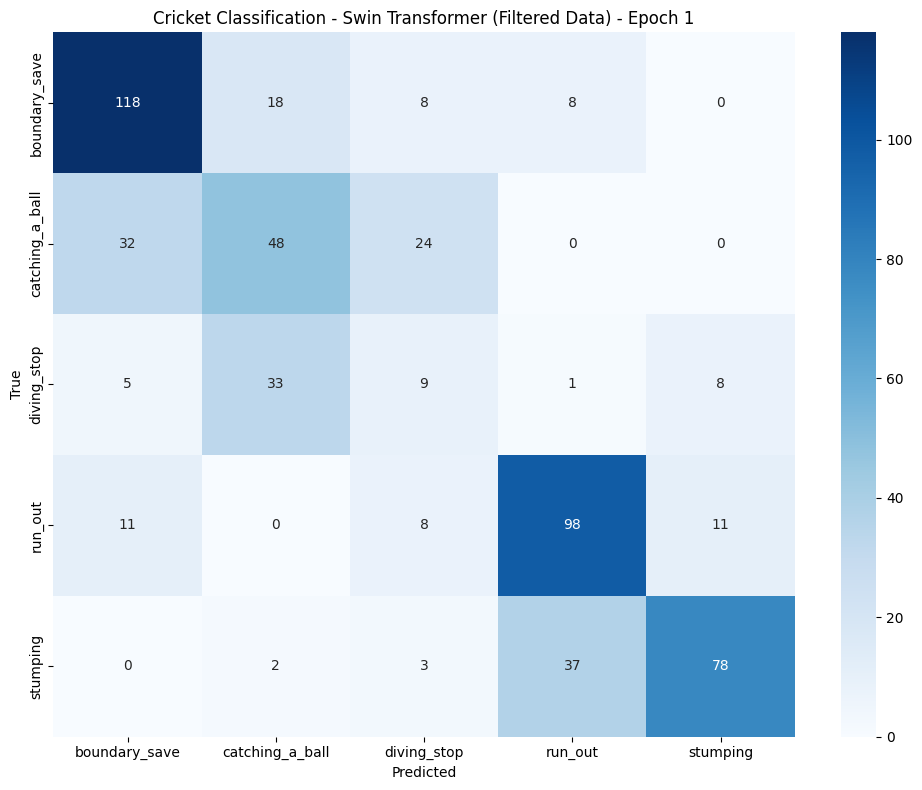

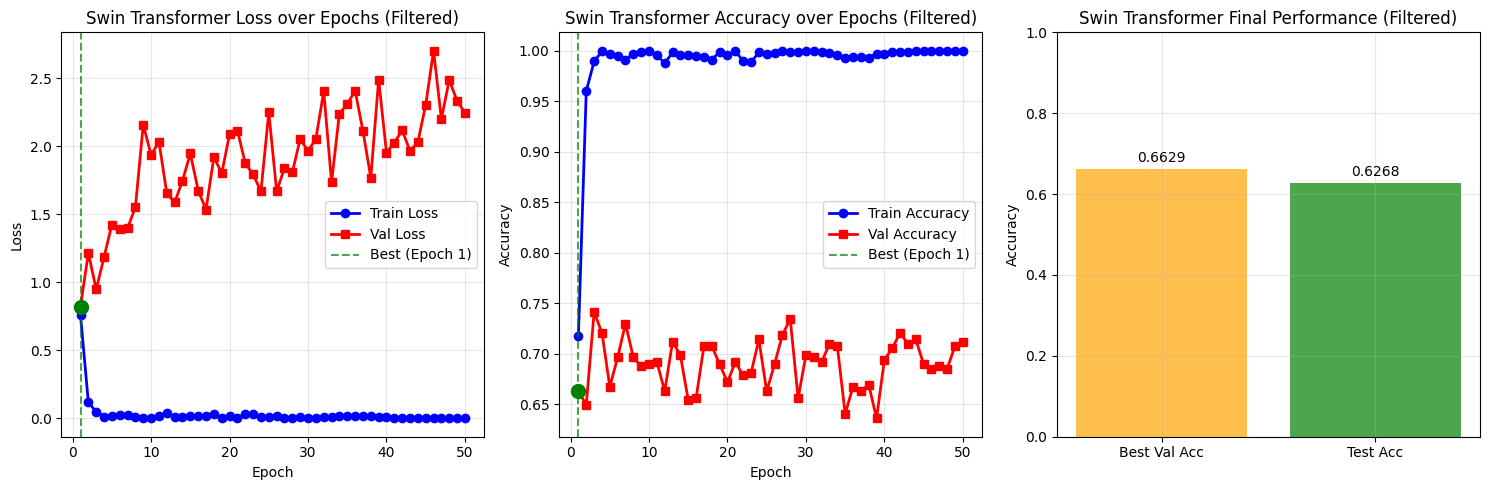


⏰ Final Timing Summary:
│ Total Training: 2214.62s (36.9 min)
│ Average per Epoch: 44.29s
│ Testing Time: 10.90s
│ Total Runtime: 2225.52s

🪟 Swin Transformer + Filtered Data Benefits:
│ Clean dataset: 'random_occlusion' folder excluded
│ Hierarchical architecture: Multi-scale feature extraction
│ Shifted windows: Efficient computation with cross-window connections
│ Linear complexity: O(H×W) instead of O(H²×W²)
│ CNNs + Transformers: Best of both architectural worlds
│ ImageNet-22k pretrained: Superior feature representations
│ Excellent performance: Often outperforms both CNNs and ViTs


In [8]:
# -----------------------------
# 3. Training Setup
# -----------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Lower LR for fine-tuning

print(f"\n📋 Training Configuration:")
print(f"│ Model: Swin Transformer Tiny (pretrained)")
print(f"│ Optimizer: Adam (lr={optimizer.param_groups[0]['lr']})")
print(f"│ Loss Function: CrossEntropyLoss")
print(f"│ Batch Size: 32")
print(f"│ Device: {device}")
print(f"│ Data: Filtered (excluding '{ignore_folder}')")

# -----------------------------
# 4. Training Loop with Model Saving
# -----------------------------
train_losses, val_losses = [], []
train_accs, val_accs = [], []
epoch_times = []
epochs = 50

# Initialize best model tracking (using val_loss for fine-tuning)
best_val_loss = float('inf')
best_model_state = None
best_epoch = 0
best_val_acc = 0.0

print(f"\n🚀 Starting Swin Transformer Fine-tuning for {epochs} epochs...")
print("=" * 80)
total_start_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()
    
    print(f"\n📈 Epoch {epoch+1}/{epochs}")
    print("-" * 50)
    
    # Training Phase
    print("🔄 Training Phase...")
    model.train()
    running_loss, correct, total = 0, 0, 0
    
    train_pbar = tqdm(train_loader, desc="Training", 
                     bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    train_phase_start = time.time()
    
    for batch_idx, (imgs, labels) in enumerate(train_pbar):
        imgs, labels = imgs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        current_acc = correct / total
        train_pbar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{current_acc:.4f}'
        })
        
        if device.type == 'cuda' and batch_idx % 10 == 0:
            gpu_memory = torch.cuda.memory_allocated() / 1024**3
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}',
                'GPU': f'{gpu_memory:.1f}GB'
            })
    
    train_phase_time = time.time() - train_phase_start
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    print(f"✅ Training completed in {train_phase_time:.2f}s")
    
    # Validation Phase
    print("🔍 Validation Phase...")
    model.eval()
    running_loss, correct, total = 0, 0, 0
    
    val_phase_start = time.time()
    val_pbar = tqdm(val_loader, desc="Validation", 
                   bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    with torch.no_grad():
        for batch_idx, (imgs, labels) in enumerate(val_pbar):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
            current_acc = correct / total
            val_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{current_acc:.4f}'
            })
    
    val_phase_time = time.time() - val_phase_start
    val_loss = running_loss / len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f"✅ Validation completed in {val_phase_time:.2f}s")
    
    # Check if this is the best model (using val_loss for fine-tuning)
    is_best = val_loss < best_val_loss
    if is_best:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_epoch = epoch + 1
        best_model_state = model.state_dict().copy()
        print(f"🌟 New best model found! Validation Loss: {val_loss:.4f}")
    
    # Epoch Summary
    epoch_time = time.time() - epoch_start_time
    epoch_times.append(epoch_time)
    
    print(f"\n📊 Epoch {epoch+1} Summary:")
    print(f"│ Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"│ Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")
    print(f"│ Train Time: {train_phase_time:.2f}s | Val Time: {val_phase_time:.2f}s")
    print(f"│ Total Epoch Time: {epoch_time:.2f}s")
    print(f"│ Best Val Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
    
    if device.type == 'cuda':
        print(f"│ GPU Memory: {torch.cuda.memory_allocated()/1024**3:.1f}GB / {torch.cuda.memory_reserved()/1024**3:.1f}GB")
    
    print("=" * 80)

total_training_time = time.time() - total_start_time

# Save the best model
if best_model_state is not None:
    torch.save(best_model_state, 'best_cricket_swin_filtered_pretrained.pth')
    print(f"\n💾 Best model saved as 'best_cricket_swin_filtered.pth'")
    print(f"📊 Best model stats:")
    print(f"│ Best Epoch: {best_epoch}")
    print(f"│ Best Val Loss: {best_val_loss:.4f}")
    print(f"│ Best Val Acc: {best_val_acc:.4f}")

# Save training history
history_data = {
    'epoch': list(range(1, epochs+1)),
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accs,
    'val_acc': val_accs,
    'epoch_time': epoch_times
}

history_df = pd.DataFrame(history_data)
history_df.to_csv('cricket_swin_filtered_history_pretrained.csv', index=False)
print("\n💾 Training history saved to 'cricket_swin_filtered_history_pretrained.csv'")

print(f"\n🎉 Swin Transformer Fine-tuning Complete!")
print(f"Total Training Time: {total_training_time:.2f}s ({total_training_time/60:.1f} minutes)")
print(f"Average Epoch Time: {np.mean(epoch_times):.2f}s")

# -----------------------------
# 5. Load Best Model and Test
# -----------------------------
print(f"\n🧪 Loading Best Model for Testing...")
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"✅ Best model from epoch {best_epoch} loaded successfully!")

test_start_time = time.time()
y_true, y_pred = [], []
model.eval()
test_pbar = tqdm(test_loader, desc="Testing", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')

with torch.no_grad():
    for imgs, labels in test_pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

test_time = time.time() - test_start_time
test_accuracy = accuracy_score(y_true, y_pred)

print(f"✅ Testing completed in {test_time:.2f}s")
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))
print(f"🎯 Test Accuracy: {test_accuracy:.4f}")

# Performance Summary
print(f"\n📊 Cricket Classification Performance (Swin Transformer - Filtered Data):")
print(f"│ Best Validation Loss: {best_val_loss:.4f} (Epoch {best_epoch})")
print(f"│ Best Validation Acc:  {best_val_acc:.4f} (Epoch {best_epoch})")
print(f"│ Final Test Accuracy:  {test_accuracy:.4f}")
print(f"│ Val-Test Gap:         {abs(best_val_acc - test_accuracy):.4f}")
print(f"│ Data Filtering: Excluded '{ignore_folder}' folder")

print(f"\n💾 Files saved:")
print(f"│ best_cricket_swin_filtered.pth - Best model weights")
print(f"│ cricket_swin_filtered_history.csv - Training metrics")

# -----------------------------
# 6. Visualizations
# -----------------------------
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Cricket Classification - Swin Transformer (Filtered Data) - Epoch {best_epoch}")
plt.tight_layout()
plt.show()

# Training Curves
plt.figure(figsize=(15, 5))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, 'b-', label="Train Loss", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_losses, 'r-', label="Val Loss", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Loss over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), train_accs, 'b-', label="Train Accuracy", marker='o', linewidth=2)
plt.plot(range(1, epochs+1), val_accs, 'r-', label="Val Accuracy", marker='s', linewidth=2)
plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best (Epoch {best_epoch})')
plt.scatter([best_epoch], [best_val_acc], color='green', s=100, zorder=5)
plt.legend()
plt.title("Swin Transformer Accuracy over Epochs (Filtered)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)

# Final Performance
plt.subplot(1, 3, 3)
metrics = ['Best Val Acc', 'Test Acc']
values = [best_val_acc, test_accuracy]
colors = ['orange', 'green']
bars = plt.bar(metrics, values, color=colors, alpha=0.7)
plt.title("Swin Transformer Final Performance (Filtered)")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
for bar, val in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
             f'{val:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Final Summary
print(f"\n⏰ Final Timing Summary:")
print(f"│ Total Training: {total_training_time:.2f}s ({total_training_time/60:.1f} min)")
print(f"│ Average per Epoch: {np.mean(epoch_times):.2f}s")
print(f"│ Testing Time: {test_time:.2f}s")
print(f"│ Total Runtime: {total_training_time + test_time:.2f}s")

# Model and Data Info
print(f"\n🪟 Swin Transformer + Filtered Data Benefits:")
print(f"│ Clean dataset: '{ignore_folder}' folder excluded")
print(f"│ Hierarchical architecture: Multi-scale feature extraction")
print(f"│ Shifted windows: Efficient computation with cross-window connections")
print(f"│ Linear complexity: O(H×W) instead of O(H²×W²)")
print(f"│ CNNs + Transformers: Best of both architectural worlds")
print(f"│ ImageNet-22k pretrained: Superior feature representations")
print(f"│ Excellent performance: Often outperforms both CNNs and ViTs")